In [1]:
import os
import shutil

train_filenames = os.listdir('train')
train_cat = filter(lambda x : x[:3]=='cat', train_filenames)
train_dog = filter(lambda x : x[:3]=='dog', train_filenames)

def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)
    
rmrf_mkdir('train2')
os.mkdir('train2/cat')
os.mkdir('train2/dog')
rmrf_mkdir('test2')
os.symlink('../test/','test2/test')

for fileName in train_cat:
    os.symlink('../../train/'+fileName, 'train2/cat/'+fileName)
for fileName in train_dog:
    os.symlink('../../train/'+fileName, 'train2/dog/'+fileName)

In [2]:
import random
import cv2
import numpy as np
from tqdm import tqdm 
TRAIN_DIR = 'train'
TEST_DIR = 'test'

ROWS = 256
COLS = 256
CHANNELS = 3

train_images = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if 'dog' in f]
train_cats =   [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if 'cat' in f]    

test_images =  [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)]

#cut down the size of train_images
#train_images = train_dogs[:1000] + train_cats[:1000]
train_images = train_dogs + train_cats
random.shuffle(train_images)
test_images =  test_images

In [3]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE #cv2.IMREAD_COLOR #cv2.IMREAD_UNCHANGED
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

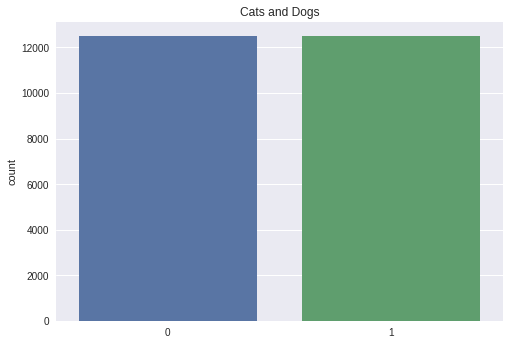

In [4]:
import seaborn as sns
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')
sns.plt.show()

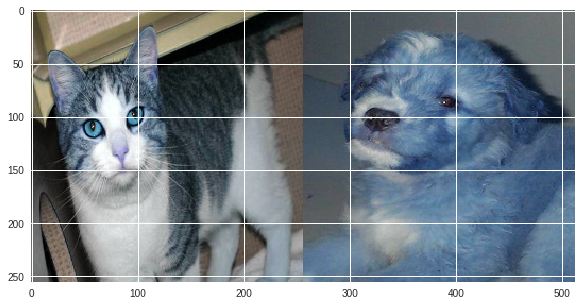

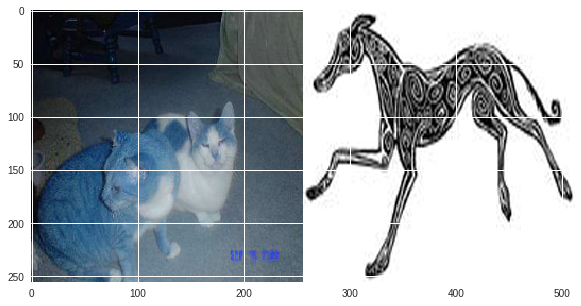

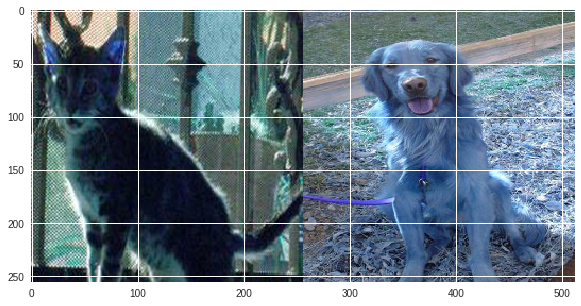

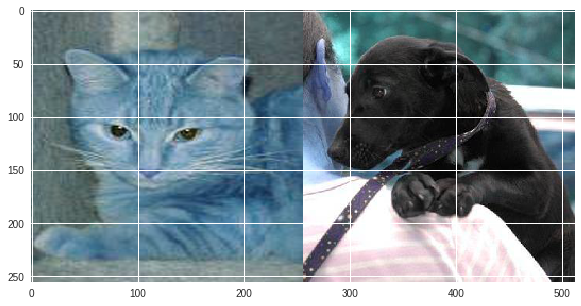

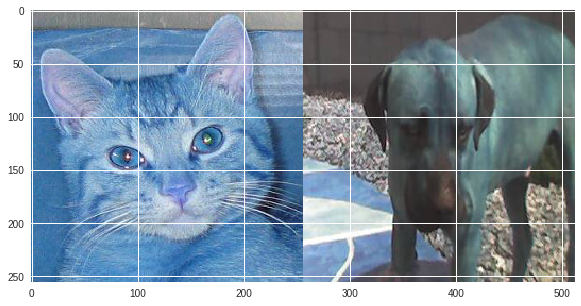

In [5]:
import matplotlib.pyplot as plt
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [6]:
train_set = train_images[:-5000]
train_labels = labels[:-5000]
valid_set = train_images[-5000:]
valid_labels = labels[-5000:]

In [7]:
sift = cv2.xfeatures2d.SIFT_create()

def preProcessImages(image_paths):
    descriptors= []
    for image_path in tqdm(image_paths):
        im = read_image(image_path)
        gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kpts, des = sift.detectAndCompute(gray_im, None)
        descriptors.append(des)
    return descriptors

In [8]:
train_descriptors = preProcessImages(train_set)

100%|██████████| 20000/20000 [15:58<00:00, 20.87it/s]


In [9]:
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.svm import SVC
flann_params = dict(algorithm = 1, trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)
bow_train = cv2.BOWKMeansTrainer(20)

def generateDic(bow_train, descriptors):
    start_time = time.time()
    for des in tqdm(descriptors):
        bow_train.add(des)
    print('Start creating dictionary')
    voc = bow_train.cluster()
    elapsed_time = time.time() - start_time
    print('elapsed time {}'.format(elapsed_time))
    return voc

def getTrainFeature(voc, bow_extract, image_paths):
    bow_extract.setVocabulary(voc)
    traindata = []
    print('Start generating features')
    for imagepath in tqdm(image_paths):
        featureset = getImagedata(sift,bow_extract,imagepath)
        traindata.extend(featureset)
    return traindata

def getImagedata(sift,bow_extract,path):
    im = read_image(path)
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    featureset = bow_extract.compute(gray_im, sift.detect(gray_im))
    return featureset

In [17]:
def trainModle(traindata, image_classes):
    #clf = LinearSVC()
    start_time = time.time()
    clf = SVC(C = 1000,kernel='rbf')
    clf.fit(traindata, np.array(image_classes))
    elapsed_time = time.time() - start_time
    print('elapsed time {}'.format(elapsed_time))
    return clf

In [11]:
import time
voc = generateDic(bow_train,train_descriptors)

100%|██████████| 20000/20000 [00:00<00:00, 917579.99it/s]


Start creating dictionary
elapsed time 2694.375564098358


In [12]:
#save the voc to local file
np.save("dictionary", voc)

In [14]:
traindata = getTrainFeature(voc, bow_extract, train_set)

  0%|          | 2/20000 [00:00<23:19, 14.29it/s]

Start generating features


100%|██████████| 20000/20000 [21:27<00:00, 14.27it/s]


In [16]:
#save the traindata to local file
import h5py
with h5py.File("trainDataFile.h5") as f:
    f.create_dataset("traindata", data= traindata)

In [18]:
#clf = train(train_descriptors, labels, train_images)
clf = trainModle(traindata,train_labels)

elapsed time 51.717934370040894


In [19]:
#save the model to local file
import pickle
pickle.dump(clf, open("clf.p", "wb") )

In [20]:
from tqdm import tqdm  

#flann_params = dict(algorithm = 1, trees = 5)     
#matcher = cv2.FlannBasedMatcher(flann_params, {})
#bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)
#bow_extract.setVocabulary( voc )
type=[]
valid_pred = []
for test_imagepath in tqdm(valid_set):
    featureset = getImagedata(sift,bow_extract,test_imagepath)
    prediction = clf.predict(featureset)
    valid_pred.append(prediction[0])
    if prediction ==1:
        predictText = "DOG"
    elif prediction ==0:
        predictText = "CAT"
    type.append(predictText)


100%|██████████| 5000/5000 [05:26<00:00, 15.70it/s]


In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(valid_labels,valid_pred)

0.64959999999999996

In [23]:
from sklearn.decomposition import PCA
#Priciple Component Analysis
pca = PCA(n_components = 'mle', svd_solver = 'full',iterated_power='auto')
pca_fit = pca.fit(traindata)
train_pca=pca_fit.transform(traindata)

In [24]:
clf_pca = trainModle(train_pca,train_labels)

elapsed time 24.042468309402466


In [25]:
testdata = []
for test_imagepath in tqdm(valid_set):
    featureset = getImagedata(sift,bow_extract,test_imagepath)
    testdata.extend(featureset)

test_pca = pca_fit.transform(testdata)
valid_pca_pred = clf_pca.predict(test_pca)

100%|██████████| 5000/5000 [05:21<00:00, 16.51it/s]


In [26]:
accuracy_score(valid_labels,valid_pca_pred)

0.65039999999999998

Optimal number of features : 10


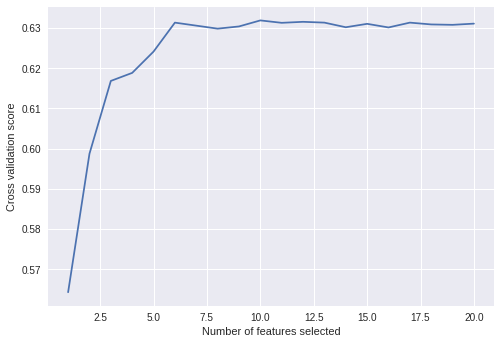

In [33]:
#feature selection exploration
from sklearn.feature_selection import RFECV

svc = SVC(kernel="linear")
featureSelector = RFECV(estimator=svc, step = 1, cv=2, scoring='accuracy')
rfecv = featureSelector.fit(traindata, train_labels)
train_rfecv = rfecv.transform(traindata) 
print("Optimal number of features : %d" % featureSelector.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(featureSelector.grid_scores_) + 1), featureSelector.grid_scores_)
plt.show()

In [34]:
test_rfe = pca_fit.transform(testdata)
valid_rfe_pred = clf_pca.predict(test_rfe)
accuracy_score(valid_labels,valid_rfe_pred)

0.65039999999999998

In [ ]:
test_images =  [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)]
#test_images =  test_images[:50]

In [ ]:
#def predict(voc,clf):
flann_params = dict(algorithm = 1, trees = 5)     
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)
bow_extract.setVocabulary( voc )

#testImageFolder = "../../../data/images/testimage/"
#testing_classes = os.listdir(testImageFolder)

testing_classes = test_images
imgPath=[]

    #for foldername in testing_classes:
        #dir = os.path.join(testImageFolder, foldername)
        #for root, dirs, files in os.walk(dir):
            #for file in files:
                #imgPath.append(dir+"/"+file)


In [ ]:
test_images[1]

In [ ]:
type=[]
for test_imagepath in test_images:
    featureset = getImagedata(sift,bow_extract,test_imagepath)
    prediction = clf.predict(featureset)
    if prediction ==1:
        predictText = "DOG"
    elif prediction ==0:
        predictText = "CAT"
    type.append(predictText)
type

In [ ]:
import matplotlib.pyplot as plt
# for test_imagepath in test_images:
#     img = read_image(test_imagepath)
#     plt.figure(figsize=(10,5))
#     plt.imshow(img)
#     plt.annotate('cat', xy=(2, 1), xytext=(10, 5))
#     plt.show()
for i in range(0,25):
    img = read_image(test_images[i])
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.annotate(type[i], xy=(2, 1),size= 25,color='#ee8d18', xytext=(10, 10))
    plt.show()

In [ ]:
a = test_images[1]
a = a.split('/')[1]
num = a.split('.')[0]
num

In [ ]:

with open('submission_file.csv','w') as f:
    f.write('id,label\n')        
with open('submission_file.csv','a') as f:
    for img in tqdm(test_images):
        temp = img.split('/')[1]
        img_num = temp.split('.')[0]
        featureset = getImagedata(sift,bow_extract,img)
        prediction = clf.predict(featureset)
        f.write('{},{}\n'.format(img_num,prediction[0]))